<a href="https://colab.research.google.com/github/basel5621/DEPI-Customer-Sentiment-and-Trend-Analysis/blob/main/LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Ub8fqb0IG6Y2qfOM1YJMP3eWnDAJbcUr' -O train.csv

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1IlceQkBYvn4VCQH5Rx7jV7rD2NjDdgkU' -O test.csv

--2024-10-07 21:10:53--  https://docs.google.com/uc?export=download&id=1Ub8fqb0IG6Y2qfOM1YJMP3eWnDAJbcUr
Resolving docs.google.com (docs.google.com)... 172.253.118.113, 172.253.118.100, 172.253.118.101, ...
Connecting to docs.google.com (docs.google.com)|172.253.118.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1Ub8fqb0IG6Y2qfOM1YJMP3eWnDAJbcUr&export=download [following]
--2024-10-07 21:10:53--  https://drive.usercontent.google.com/download?id=1Ub8fqb0IG6Y2qfOM1YJMP3eWnDAJbcUr&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.118.132, 2404:6800:4003:c05::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.118.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39529308 (38M) [application/octet-stream]
Saving to: ‘train.csv’

train.csv           100%[===================>]  37.70M  32.5MB/s    

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [ ]:
df_train.head()

,cleaned_text,label
0,already tested blood 1947 long game ethnic cle...,1.0
1,yep thats hate bad,0.0
2,dream,1.0
3,uk first past post electoral system broken lea...,0.0
4,excited welcome one newest member team michell...,1.0


In [ ]:
X=df_train['cleaned_text'].astype(str)
y=df_train['label']

X_test=df_test['cleaned_text'].astype(str)
y_test=df_test['label']

X.info()

<class 'pandas.core.series.Series'>
RangeIndex: 441353 entries, 0 to 441352
Series name: cleaned_text
Non-Null Count   Dtype 
--------------   ----- 
441353 non-null  object
dtypes: object(1)
memory usage: 3.4+ MB


In [ ]:
X_token=X.apply(word_tokenize)
model_w2v = Word2Vec(X_token, vector_size=200, window=5, min_count=1, workers=8, sg=0)

In [ ]:
print(model_w2v.wv.most_similar('happy'))

[('happyhappy', 0.6809318661689758), ('134th', 0.6644383668899536), ('happiest', 0.6451311707496643), ('blessed', 0.631690263748169), ('simpply', 0.6239885091781616), ('thankful', 0.6224609017372131), ('grateful', 0.6189372539520264), ('heppy', 0.6159093976020813), ('glad', 0.605090320110321), ('happpppppppppyyyyy', 0.5954805016517639)]


In [ ]:
print(model_w2v.wv.most_similar('love'))

[('loved', 0.5922670960426331), ('friendship', 0.5758945345878601), ('adore', 0.5702295899391174), ('joy', 0.5659862756729126), ('appreciate', 0.5468706488609314), ('enjoy', 0.5419337749481201), ('amazing', 0.54052734375), ('kindness', 0.540336549282074), ('forever', 0.535307765007019), ('hate', 0.5346246361732483)]


In [ ]:
model_w2v.save("word2vec.model")

In [ ]:
loaded_model = Word2Vec.load("word2vec.model")

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

vocab_size = len(tokenizer.word_index)+1

X_train_seq = tokenizer.texts_to_sequences(X)

max_len = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq , maxlen=max_len , padding='post')
vocab_size

181849

In [ ]:
embedding_dim = model_w2v.vector_size  # 300 in your case
embedding_matrix = np.zeros((vocab_size, model_w2v.vector_size))
for word, i in tokenizer.word_index.items():
    if word in model_w2v.wv:
        embedding_matrix[i] = model_w2v.wv[word]
    else:
        embedding_matrix[i] = np.random.normal(size=(embedding_dim,))

In [ ]:
embedding_matrix.shape

(181849, 200)

In [ ]:
from tensorflow.keras import regularizers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense ,Dropout
from tensorflow.keras import layers


BI_LSTM_model = Sequential([
    layers.Input(shape=(max_len,)),
    layers.Embedding(input_dim=vocab_size, output_dim=model_w2v.vector_size, weights=[embedding_matrix], trainable=False),
    layers.Bidirectional(layers.LSTM(256, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))),
    layers.GlobalMaxPool1D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

BI_LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

BI_LSTM_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 68, 200)             │      36,369,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 68, 512)             │         935,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 512)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,371,529 (142.56 MB)

 Trainable params: 1,001,729 (3.82 MB)

 Non-trainable params: 36,369,800 (138.74 MB)

In [ ]:
BI_history=BI_LSTM_model.fit(X_train_padded, y, epochs=100, batch_size=512, validation_split=0.1,callbacks=[early_stopping])

Epoch 1/100
776/776 ━━━━━━━━━━━━━━━━━━━━ 73s 85ms/step - accuracy: 0.9661 - loss: 0.9782 - val_accuracy: 0.9870 - val_loss: 0.0518
Epoch 2/100
776/776 ━━━━━━━━━━━━━━━━━━━━ 66s 85ms/step - accuracy: 0.9844 - loss: 0.0556 - val_accuracy: 0.9862 - val_loss: 0.0474
Epoch 3/100
776/776 ━━━━━━━━━━━━━━━━━━━━ 82s 85ms/step - accuracy: 0.9848 - loss: 0.0522 - val_accuracy: 0.9865 - val_loss: 0.0486
Epoch 4/100
776/776 ━━━━━━━━━━━━━━━━━━━━ 82s 85ms/step - accuracy: 0.9851 - loss: 0.0503 - val_accuracy: 0.9865 - val_loss: 0.0476
Epoch 5/100
776/776 ━━━━━━━━━━━━━━━━━━━━ 82s 85ms/step - accuracy: 0.9854 - loss: 0.0495 - val_accuracy: 0.9872 - val_loss: 0.0453
Epoch 6/100
776/776 ━━━━━━━━━━━━━━━━━━━━ 82s 85ms/step - accuracy: 0.9855 - loss: 0.0485 - val_accuracy: 0.9868 - val_loss: 0.0443
Epoch 7/100
776/776 ━━━━━━━━━━━━━━━━━━━━ 66s 85ms/step - accuracy: 0.9854 - loss: 0.0469 - val_accuracy: 0.9866 - val_loss: 0.0448
Epoch 8/100
776/776 ━━━━━━━━━━━━━━━━━━━━ 83s 85ms/step - accuracy: 0.9858 - loss: 0

<Axes: >

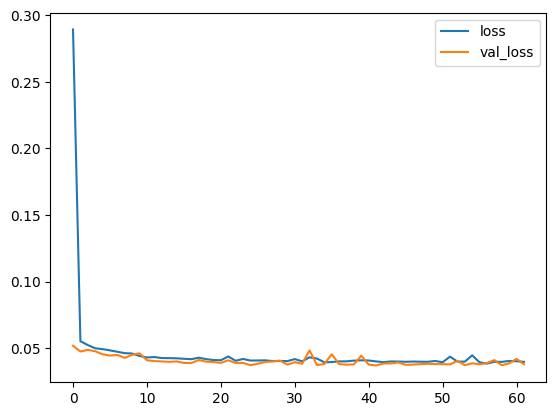

In [ ]:
df_hist_BI=pd.DataFrame(BI_history.history)
df_hist_BI[['loss','val_loss']].plot()

In [ ]:
BI_LSTM_model.save("BI_LSTM_model.keras")

## Testing

In [ ]:
def prepare_test(X_test):
    X_test_seq = tokenizer.texts_to_sequences(X_test.tolist())
    X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')
    return X_test_padded

X_test_padded = prepare_test(X_test)
BI_LSTM_model.evaluate(X_test_padded, y_test)

1533/1533 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9873 - loss: 0.0381


[0.03688432648777962, 0.9877243041992188]

In [ ]:
def Predict(X_test,model):
    X_test_padded = prepare_test(X_test)
    return model.predict(X_test_padded)

def Evaluate(X_test,y_test,model):
    y_pred=Predict(X_test,model)
    y_pred_binary = (y_pred > 0.5).astype(int)
    accuracy = np.mean(y_pred_binary == y_test)
    return accuracy

## Build The CNN model

In [ ]:
from tensorflow.keras import regularizers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense ,Dropout
from tensorflow.keras import layers


model = Sequential([
    layers.Input(shape=(max_len,)),
    layers.Embedding(input_dim=vocab_size, output_dim=model_w2v.vector_size, weights=[embedding_matrix], trainable=False),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.GlobalMaxPool1D(),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 68, 200)             │      36,369,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 68, 256)             │         336,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,723,209 (140.09 MB)

 Trainable params: 353,409 (1.35 MB)

 Non-trainable params: 36,369,800 (138.74 MB)

In [ ]:
history = model.fit(X_train_padded, y, epochs=20, batch_size=512, validation_split=0.2)

Epoch 1/20
690/690 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.9618 - loss: 0.0920 - val_accuracy: 0.9879 - val_loss: 0.0321
Epoch 2/20
690/690 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.9871 - loss: 0.0345 - val_accuracy: 0.9881 - val_loss: 0.0307
Epoch 3/20
690/690 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.9876 - loss: 0.0327 - val_accuracy: 0.9882 - val_loss: 0.0305
Epoch 4/20
690/690 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.9882 - loss: 0.0318 - val_accuracy: 0.9880 - val_loss: 0.0309
Epoch 5/20
690/690 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.9880 - loss: 0.0322 - val_accuracy: 0.9882 - val_loss: 0.0308
Epoch 6/20
690/690 ━━━━━━━━━━━━━━━━━━━━ 29s 43ms/step - accuracy: 0.9886 - loss: 0.0309 - val_accuracy: 0.9881 - val_loss: 0.0307
Epoch 7/20
690/690 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.9892 - loss: 0.0293 - val_accuracy: 0.9879 - val_loss: 0.0311
Epoch 8/20
690/690 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.9898 - loss: 0.0291 - 

In [ ]:
model.evaluate(X_test_padded, y_test)

1533/1533 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9872 - loss: 0.0500


[0.04828450828790665, 0.9875203967094421]

In [ ]:
model.save("BI_LSTM_model_low_loaded.keras")